[View in Colaboratory](https://colab.research.google.com/github/sungreong/Pymc3_bayseian/blob/master/Bayesian_Estimation_Supersedes_the_T_Test.ipynb)

In [0]:
!pip install git+https://github.com/pymc-devs/pymc3

In [2]:

%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.4.1


## 문제

Drug trial evaluation 

베이지안 추론 저급이 실제로 얼마나 잘 먹히는지에 대해서 우리는 2012 임상실험 평가 예제를 사용하겠다.  

개인의 아이큐를 비교하는 지성을 증가시키기 위해 효율성을 측정하는것이 실험의 목적이다. 


  group  value
0  drug    101
1  drug    100
2  drug    102
3  drug    104
4  drug    102


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe27d5890d0>,
      dtype=object)

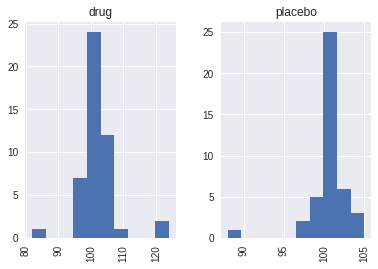

In [3]:
drug = (101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101)
placebo = (99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99)

y1 = np.array(drug)
y2 = np.array(placebo)
y = pd.DataFrame(dict(value=np.r_[y1, y2], group=np.r_[['drug']*len(drug), ['placebo']*len(placebo)]))

print(y.head())
y.hist("value", by="group")

베이지안 접근에서 추론의 첫번째 단계는 문제에 관한 완전한 확률 모델을 구체화하는 것이다.  
예로 크러스키는 각각의 스코어의 분포를 설명하기 위해  t 분포를 선택했다.  
이 선택은 분석에 강건함을 더해줬다. 왜냐하면 t 분포는 outlier에 덜 민감하기 때문이다 노말에 비해서  
t 분포의 3개의 파라미터는 mean $ \mu $ precision $ \lambda $  degree of freedom parameter $\nu $

$ f(x|\mu ,\lambda, \nu)= \frac{\Gamma(\frac{\nu+1}{2})} {\Gamma(\frac{ν}{2})}\frac{\lambda}{\pi\nu}^{\frac{1}{2}}[1+\frac{\lambda(x−\mu)^2}{\nu}]^{\frac{−(ν+1)}{2}} $ 

자유도 파라미터는 필수적으로 data 의 정규성을 구체화한다. 때문에 큰 자유도 $\nu $ 는 분포를 normal로 수렴하게 만든다.  
반약에 작은 자유도 즉 0에 가까우면 두꺼운 꼬리를 만든다.  

그러마로 가능도 함수를 구체화 하면

$ y_{i}^{treat} \sim T(\nu, \mu_1, \sigma_1) $

$ y_{i}^{treat} \sim T(\nu, \mu_2, \sigma_2) $

가정을 간단하게 할 때 우리는 정규성 $\nu$ 의 양을 가정한다. (두 그룹을 갖게)  
대신 $\mu , \sigma $ 는 서로 다르게 놔둔다.  
때문에 평균은 실제 값이고 우리는 노말 분포를 사전분포로 하고 pooled empricla  mean 을 적용한다. 
$ \mu_k \sim N(\bar{a} , 2S) $



In [0]:
mu_m = y.value.mean()
mu_s = y.value.std() * 2

with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', mu_m, sd=mu_s)
    group2_mean = pm.Normal('group2_mean', mu_m, sd=mu_s)

그룹의 표준편차는 결과변수의 변수랄 유연한 범위의 유니폼 사전을 주어진다.  

만약에 넓은 유니폼 사전 분포를 주어지면 너는 값을 놓치지 않고 많은 사전 가중치를 줄 수 있다.  
거의 실용적이지 않지만 그러나 일반적으로 큰 사전정보를 적용하는 것이 좋다.

$ Uniform(1, 10) prior $ 

In [0]:
sigma_low=1
sigma_high =10

with model:
    group1_std = pm.Uniform('group1_std', lower=sigma_low, upper=sigma_high)
    group2_std = pm.Uniform('group2_std', lower=sigma_low, upper=sigma_high)


우리는 Kruschke에 따라 ν를 기하 급수적으로 분포시켜 평균 30으로 만든다.  

이것은 Student-T 분포 하에서 정상에서 큰 꼬리까지의 범위를 기술하는 매개 변수 영역에 대해 높은 사전 확률을 할당합니다.  

pymc3 student t 는 표준편차 보다는 precision(표준편차의 역수) 를 모수화 한다.  
우리는 우리의 가능도 함수를 구체화하기전에 표준편차로 변경시켜줘야 한다. 

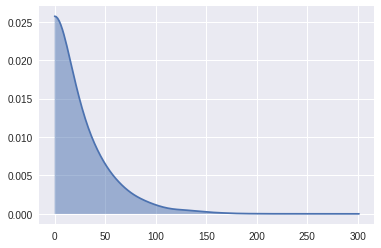

In [9]:
with model:
    nu = pm.Exponential('nu_minus_one', 1/29.) + 1

pm.kdeplot(np.random.exponential(30, size=10000), shade=0.5);

In [0]:
with model:
    lambda1 = group1_std**-2
    lambda2 = group2_std**-2

    group1 = pm.StudentT('drug', nu=nu, mu=group1_mean, lam=lambda1, observed=y1)
    group2 = pm.StudentT('placebo', nu=nu, mu=group2_mean, lam=lambda2, observed=y2)

완전히 구체화된 확률모델을 가지면서 우리는 약의 효과를 평가하기 위해 비교량을 계산할 수 있다.  
마지막으로 우리는 deterministic nodes를 구체화한다. 그룹 평균과 그룹 표준 편차 각각의 사이에 차이를 보기 위해  
Deterministic 으로 감싸서 pymc 사용해야한다.  

  we will also estimate the “effect size”, which is the difference in means scaled by the pooled estimates of standard deviation.   
  This quantity can be harder to interpret, since it is no longer in the same units as our data, but the quantity is a function of all four estimated parameters.

In [0]:
with model:
    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))

In [12]:
with model:
    trace = pm.sample(2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_minus_one, group2_std, group1_std, group2_mean, group1_mean]
100%|██████████| 2500/2500 [00:07<00:00, 355.57it/s]
/usr/local/lib/python2.7/dist-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/local/lib/python2.7/dist-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


확률적인 파라미터를 그림을 그릴  수 있다. (plot_posterior)    
유익한 히스토그램을 볼 수 있고 95 % 신뢰구간도 나타내고 사후 평균도 알 수 있다.  

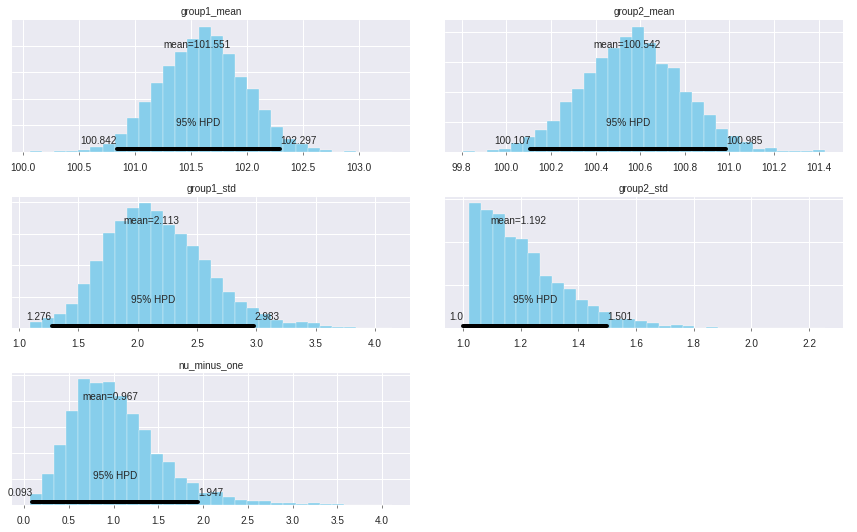

In [18]:
pm.plot_posterior(trace, varnames=['group1_mean','group2_mean', 'group1_std', 'group2_std', 'nu_minus_one'],color='#87ceeb');


그룹 간 차이를 보라 우리는 모든 세가지 측정에서 두그룹사이에 차이가 있다는 것으로 결론지었다.   
ref_val 이라는 변수 참조로써 0을 사용하기위 유용하다.  사후 분포의 누적 확률은 참조값을 출력한다.   
그러므로  평균의 차이는 사후 확률의 99.4 % 는 제로보다 크다, 그것은 차이가 있다는 것을 알 수 있다.  
the effect size 와 표준 오차의 차이는 유사하게 양이다



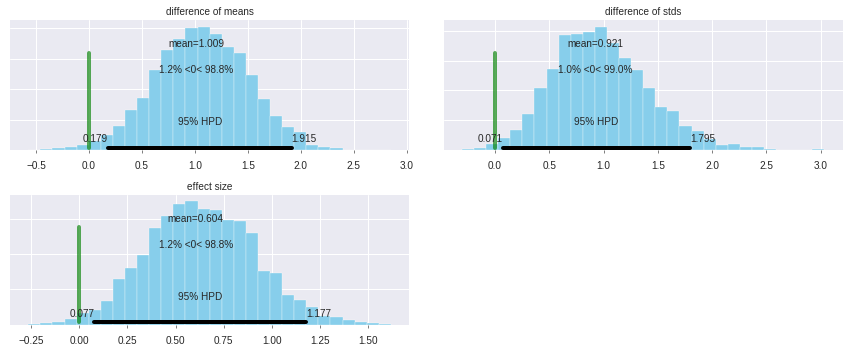

In [20]:

pm.plot_posterior(trace, varnames=['difference of means','difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb');

forestplot 는 여러 체인을 가질 때 수렴의 부족의 증거를 드러내는데 사용하는 잠재적인 스케일 감축 파라미터 또한 그릴 수 있다. 

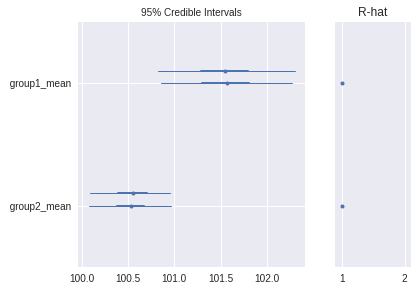

In [21]:
pm.forestplot(trace, varnames=['group1_mean',
                               'group2_mean']);


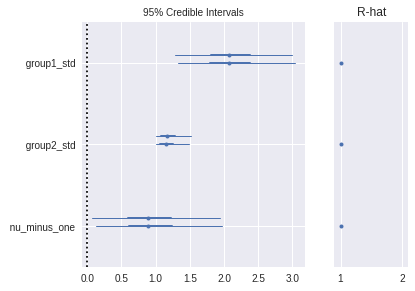

In [23]:
pm.forestplot(trace, varnames=['group1_std',
                               'group2_std',
                               'nu_minus_one']);

In [24]:
pm.summary(trace,varnames=['difference of means', 'difference of stds', 'effect size'])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
difference of means,1.009367,0.443065,0.007835,0.179469,1.914821,3383.698251,1.000760
difference of stds,0.920990,0.447452,0.006564,0.070684,1.795330,3595.580542,0.999798
effect size,0.604090,0.281546,0.004646,0.077258,1.177089,3605.935180,1.000367
